# PoC RNN Polymer
Matt Hagy (<matthew.hagy@gmail.com>), Februrary 16th, 2018

Very preliminary proof-of-concept work in analyzing a recurrent neural network (RNN) using basic polymer theory. I myself am a novice with RNN theory and I've forgotten most of the polymer theory I used to know and, therefore, I believe there is significant potential to further advance this naive PoC work.

This PoC builds off the excellent example of using RNNs for interpreting dates in varied human formats by Zafarali Ahmed in [keras-attention](https://github.com/datalogue/keras-attention). E.g., converting “November 5, 2016” to “2016–11–05”. I’m simply studying the structure of the RNN states using an RNN developed in that work.

I focus on the 512 encoder units within the LSTM layer of this RNN. I treat each encoder as a linear polymer chain growing in 1-dimension. I explore the dynamics of each encoder unit for different input strings. The autocorrelation function for each encoder unit is computed to quantify the encoders dynamics for each example input string. 

Some references I used in developing this work.
* [How to Visualize Your Recurrent Neural Network with Attention in Keras](https://medium.com/datalogue/attention-in-keras-1892773a4f22)
* [Visualizing and Understanding Recurrent Networks](https://arxiv.org/abs/1506.02078)
* [Visualizing LSTM Networks. Part I](https://medium.com/asap-report/visualizing-lstm-networks-part-i-f1d3fa6aace7)
* [Neural network applications in polymerization processes](http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-66322005000300009)
* [LSTM Visualization Example](https://github.com/asap-report/lstm-visualisation)
* [Tutorial: LSTM Networks for Sentiment Analysis](http://deeplearning.net/tutorial/lstm.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
from keras.models import Model

Using TensorFlow backend.


In [2]:
# include companion project keras-attention
import sys
sys.path.append('../keras-attention')

## Load trained model
Load trained model. Follow instructions in [keras-attention](https://github.com/datalogue/keras-attention) to get a trained model. I recommend using a GPU-equipped VM on AWS EC2.

In [3]:
from data.reader import Vocabulary, Data
from models.NMT import simpleNMT

In [4]:
padding = 50
input_vocab = Vocabulary('../keras-attention/data/human_vocab.json', padding=padding)
output_vocab = Vocabulary('../keras-attention/data/machine_vocab.json', padding=padding)

In [5]:
pred_model = simpleNMT(trainable=False,
                       pad_length=padding,
                       n_chars=input_vocab.size(),
                       n_labels=output_vocab.size())

inputs shape: (?, ?, 512)


In [6]:
# load the weights from training
pred_model.load_weights('../keras-attention/weights/NMT.50-0.01.hdf5', by_name=True)

## Model structure
Show the high-level layers used to build this RNN

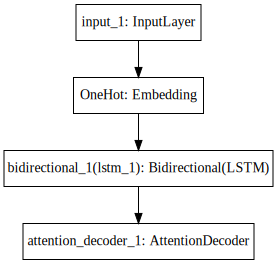

In [7]:
SVG(model_to_dot(pred_model).create(prog='dot', format='svg'))

## Example
Example of applying the model on an example input string.

In [8]:
encoded = np.array([input_vocab.string_to_int('February 16th 2018')])
full_prediction = pred_model.predict(encoded)
prediction = np.argmax(full_prediction[0], axis=-1)
output_vocab.int_to_string(prediction)[:14]

['2',
 '0',
 '1',
 '8',
 '-',
 '0',
 '2',
 '-',
 '1',
 '6',
 '<eot>',
 '<unk>',
 '<unk>',
 '<unk>']

In [9]:
full_prediction.shape

(1, 50, 13)

## Analyze LSTM output sequence for example
Fetch the bidirectional LSTM layer and compute the LSTM output sequence for the example input.

In [10]:
intermediate_layer_model = Model(inputs=pred_model.input,
                                 outputs=pred_model.get_layer('bidirectional_1').output)
intermediate_output = intermediate_layer_model.predict(encoded)
intermediate_output.shape

(1, 50, 512)

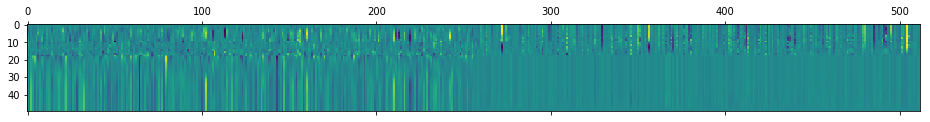

In [11]:
# Visualize the 512 LSTM output sequences
plt.matshow(intermediate_output[0])

In [12]:
# Sample random encoders to show examples
ix = np.arange(intermediate_output.shape[2])
np.random.RandomState(0xCAFE).shuffle(ix)
ix = ix[:5]

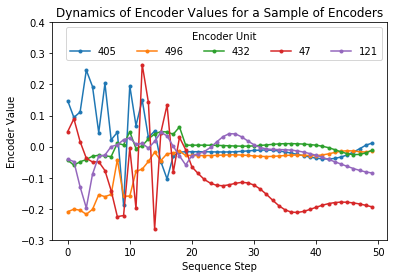

In [13]:
# Plot encoder unit dynamics for a sample of units
for index in ix:
    plt.plot(intermediate_output[0, ::, index], marker='.', label=str(index))
plt.xlabel('Sequence Step')
plt.ylabel('Encoder Value')
plt.title('Dynamics of Encoder Values for a Sample of Encoders')
plt.ylim(-0.3, 0.4)
plt.legend(loc='upper right', title='Encoder Unit', ncol=5)

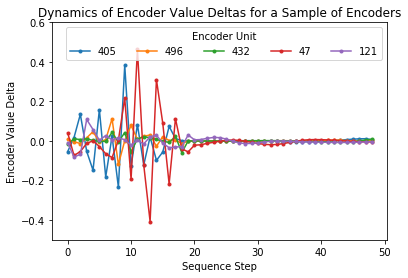

In [14]:
# Plot the deltas of dynamics
for index in ix:
    x = intermediate_output[0, ::, index]
    plt.plot(x[1::] - x[:-1:], marker='.', label=str(index))
plt.xlabel('Sequence Step')
plt.ylabel('Encoder Value Delta')
plt.title('Dynamics of Encoder Value Deltas for a Sample of Encoders')
plt.ylim(-0.5, 0.6)
plt.legend(loc='upper right', title='Encoder Unit', ncol=5)

## Compute sequences for a sample of random input strings

In [15]:
# Load example validation inputs
validation = Data('../keras-attention/data/validation.csv', input_vocab, output_vocab)
validation.load()
print(len(validation.inputs))
validation.inputs[:10]

1000


['25 set, 2002',
 '27, Jan 2017',
 '4 Me, 2000',
 'مارس 29 2007',
 '6 أغسطس 1983',
 '25 Mar 2007',
 '29 1月, 2019',
 '15/11/13',
 'Monday, 29 August 1983',
 '26 11月, 2007']

In [16]:
def compute_lstm_sequence_for_input(input_string):
    encoded = np.array([input_vocab.string_to_int(input_string)])
    intermediate_output = intermediate_layer_model.predict(encoded)
    return intermediate_output[0]

lstm_sequences = [compute_lstm_sequence_for_input(i) for i in tqdm(validation.inputs)]

100%|██████████| 1000/1000 [01:01<00:00, 16.35it/s]


In [17]:
lstm_sequences = np.array(lstm_sequences)
lstm_sequences.shape

(1000, 50, 512)

In [18]:
lstm_rms_delta = np.mean(
    np.sqrt((lstm_sequences[::, 1::, ::] - lstm_sequences[::, :-1:, ::]) ** 2),
    axis=0
)
lstm_rms_delta.shape

(49, 512)

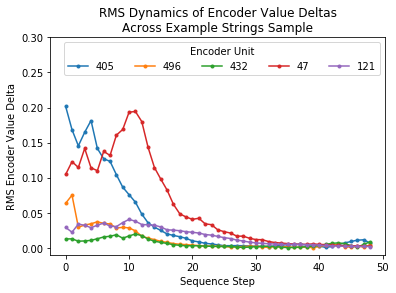

In [19]:
for index in ix:
    plt.plot(lstm_rms_delta[::, index], marker='.', label=str(index))
plt.xlabel('Sequence Step')
plt.ylabel('RMS Encoder Value Delta')
plt.title('RMS Dynamics of Encoder Value Deltas\nAcross Example Strings Sample')
plt.ylim(-0.01, 0.3)
plt.legend(loc='upper right', title='Encoder Unit', ncol=5)

## Distribution of Sum RMS Delta
For each encoder RMS dynamics, I sum the function to determine the extent to which the encoder has interesting dynamics.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Distribution Density')

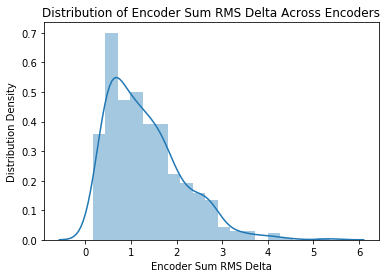

In [20]:
lstm_rms_delta_sum = pd.Series(lstm_rms_delta.sum(axis=0))
sns.distplot(lstm_rms_delta_sum)
plt.title('Distribution of Encoder Sum RMS Delta Across Encoders')
plt.xlabel('Encoder Sum RMS Delta')
plt.ylabel('Distribution Density')

In [21]:
(lstm_rms_delta_sum
 .describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]).round(1)
 .to_frame()
 .T)

,count,mean,std,min,50%,75%,90%,95%,99%,max
0,512.0,1.3,0.8,0.2,1.1,1.8,2.5,2.8,3.7,5.4


## Interpretation
From the distribution, we can see that most encoders have a small sum RMS delta. I interpret this to mean that most encoders don’t have particularly interesting dynamics. A small number of encoders appear to have richer dynamics and these will be investigated in the following analysis.


In [22]:
top_dynamics = lstm_rms_delta_sum.sort_values(ascending=False).head()
top_dynamics

309    5.361094
436    4.454443
346    4.100636
214    4.030795
50     4.005840
dtype: float32

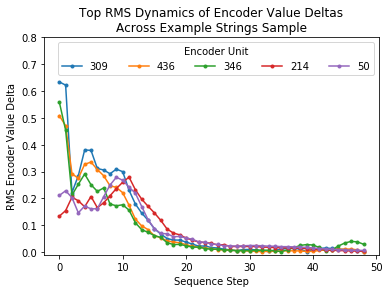

In [23]:
for index in top_dynamics.index:
    plt.plot(lstm_rms_delta[::, index], marker='.', label=str(index))
plt.xlabel('Sequence Step')
plt.ylabel('RMS Encoder Value Delta')
plt.title('Top RMS Dynamics of Encoder Value Deltas\nAcross Example Strings Sample')
plt.ylim(-0.01, 0.8)
plt.legend(loc='upper right', title='Encoder Unit', ncol=5)

## Discussion
In this work, I’ve investigated the dynamics of LSTM encoder units on a sample of input strings by treating each encoder as a single linear polymer chain growing in one dimension. Encoders generally show rich and varied dynamics in the early stages; i.e., when consuming the beginning of a input sequence of characters. At later stages, the dynamics are found to stabilize towards a terminal value. This can be explained by most input strings having `<pad>` characters that fill out the end of each input sequence. We’d expect such `<pad>` characters to have a negligible impact on changing the value of each encoder.

Interestingly, the majority of encoders have relatively low magnitude dynamics on average as quantified over a sample of input strings. A small number of encoders show larger magnitude dynamics and are visualized in the last figure of this work. There are some similarities in the shape of these correlation functions at short to intermediate time scales.

Seeing as I know very little about RNNs and polymer dynamics, I’d imagine other people could do much more interesting things with these ideas. Further, I don’t know to what extent the results of this work are covered in existing prior work. It’s possible such RNN dynamics have already been quantified in a related fashion. 
